In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib
import datetime

timer = mypackage.Timer()

def print_current_time():
    print(datetime.datetime.now())

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [3]:
import datetime

def print_current_time():
    print(datetime.datetime.now())
    
print_current_time()

2020-05-13 15:32:13.133090


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[:4], X_test_orig[:4], Y_train_orig[:4], Y_test_orig[:4]
# channels_used = [7, 40, 68, 138, -1]
# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[..., channels_used], X_test_orig[..., channels_used], Y_train_orig[..., channels_used], Y_test_orig[..., channels_used]

X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')
# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# load the scaler from disk
scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=0.3: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [4]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 3 # Each HybridSN takes 1 hour to run with m=3 and PCA->30
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=0.0)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=0.0)
#######################################################

X_train_HS.shape, X_test_HS.shape

((126, 56, 56, 208), (57, 56, 56, 208))

# Test HybridSN

2020-05-12 23:56:11.249318
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (No

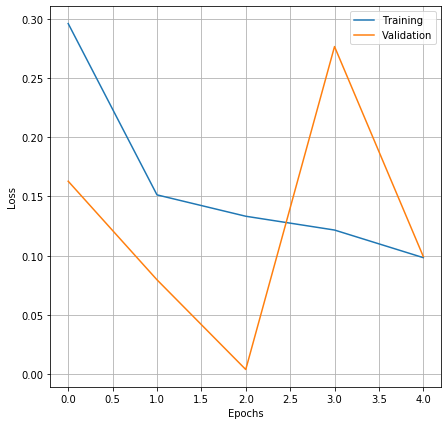

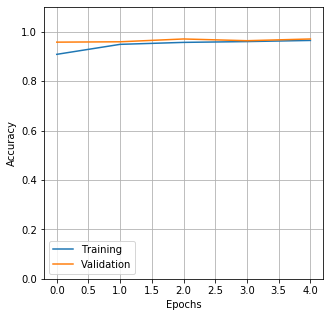

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     38985
         1.0       0.94      0.96      0.95     18039
         2.0       0.82      0.64      0.72      1344

    accuracy                           0.97     58368
   macro avg       0.92      0.86      0.89     58368
weighted avg       0.97      0.97      0.97     58368



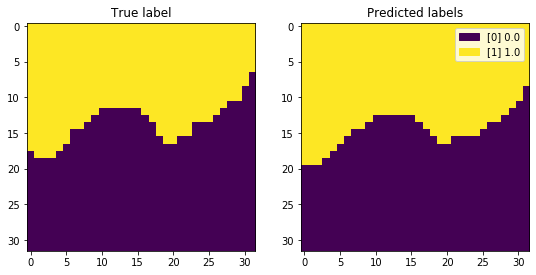

Elapsed time: 586.6562 seconds
Fasle positive blobs 38.
Fasle positive blobs per image 0.6667


In [7]:
print_current_time()

model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
# model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test_HS)

In [4]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (-7.476554870605469, 12.313852310180664) (570, 32, 32, 208) (1260, 32, 32, 208)
(array([0., 1., 2.]), array([891455, 364161,  34624]))
(array([0., 1., 2.]), array([382009, 186684,  14987]))


# Testing SVM

In [9]:
# Started the training at ~16:30
# Finished training at ~17:00

In [10]:
Y_train_orig.shape, Y_test_orig.shape, X_train_orig.shape

((42, 100, 100, 1), (19, 100, 100, 1), (42, 100, 100, 208))

2020-05-13 02:55:43.379974
[LibSVM]Elapsed time: 4251.8629 seconds
Elapsed time: 2109.1566 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    453973
         1.0       0.97      0.96      0.97    122389
         2.0       0.87      0.75      0.81      7318

    accuracy                           0.99    583680
   macro avg       0.95      0.90      0.92    583680
weighted avg       0.99      0.99      0.99    583680

Fasle positive blobs 203.
Fasle positive blobs per image 0.3561


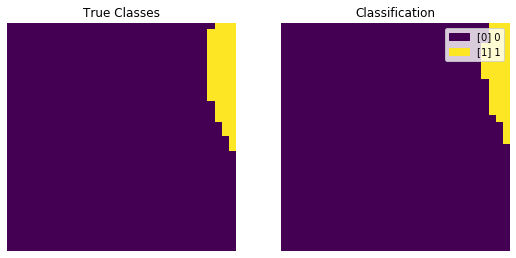

In [11]:
print_current_time()

svm = mypackage.SVM(X_train_orig, Y_train_orig, C=10, kernel='rbf', gamma=0.1)
svm.train()
# svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

### Linear - SVM

2020-05-13 04:41:45.283062
[LibSVM]Elapsed time: 1551.1442 seconds
Elapsed time: 3243.4765 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00   1074499
         1.0       0.96      0.97      0.96    201215
         2.0       0.93      0.69      0.79     14526

    accuracy                           0.99   1290240
   macro avg       0.96      0.88      0.92   1290240
weighted avg       0.99      0.99      0.99   1290240

Elapsed time: 1465.3082 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    453973
         1.0       0.98      0.96      0.97    122389
         2.0       0.91      0.71      0.80      7318

    accuracy                           0.99    583680
   macro avg       0.96      0.89      0.92    583680
weighted avg       0.99      0.99      0.99    583680

Fasle positive blobs 46.
Fasle positive blobs per image 0.0807


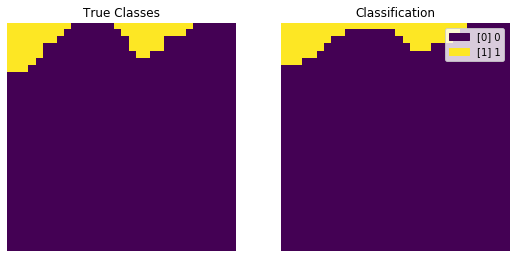

In [12]:
print_current_time()

svm = mypackage.SVM(X_train_orig, Y_train_orig, C=0.1, kernel='linear')
svm.train()
svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

In [13]:
# mypackage.plot_labeled_images(Y_hat, Y_test_svm)

# Testing Logistic Regression

2020-05-13 06:26:07.574308
Elapsed time: 678.9605 seconds
Elapsed time: 0.7714 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1074499
         1.0       0.95      0.96      0.96    201215
         2.0       0.91      0.58      0.71     14526

    accuracy                           0.99   1290240
   macro avg       0.95      0.84      0.89   1290240
weighted avg       0.99      0.99      0.99   1290240

Elapsed time: 0.3546 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    453973
         1.0       0.97      0.95      0.96    122389
         2.0       0.89      0.67      0.76      7318

    accuracy                           0.98    583680
   macro avg       0.95      0.87      0.91    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 91.
Fasle positive blobs per image 0.1596


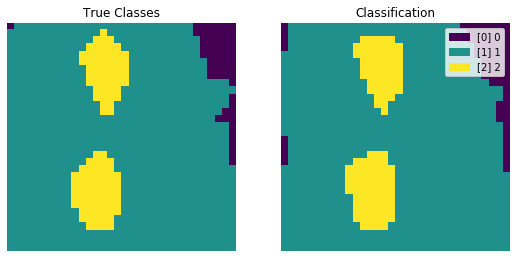

In [14]:
print_current_time()

logreg = mypackage.LogReg(X_train_orig, Y_train_orig, C=1, penalty='l2', saved_mode_name="latest_LogisticReg_l2_model.sav")# , max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

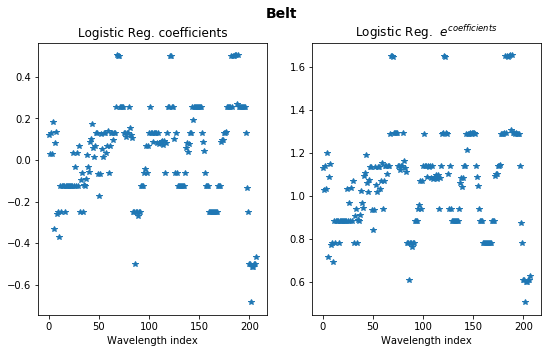

Ordered four most useful wavelengths are: [1602, 1609, 1173, 1599]nm
There corresponding indexes are: [187 189  68 186]


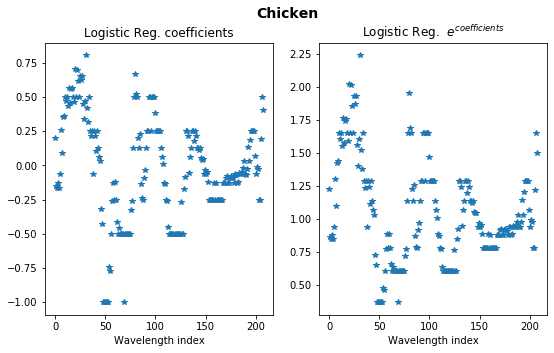

Ordered four most useful wavelengths are: [1040, 1000, 1007, 1216]nm
There corresponding indexes are: [31 20 22 80]


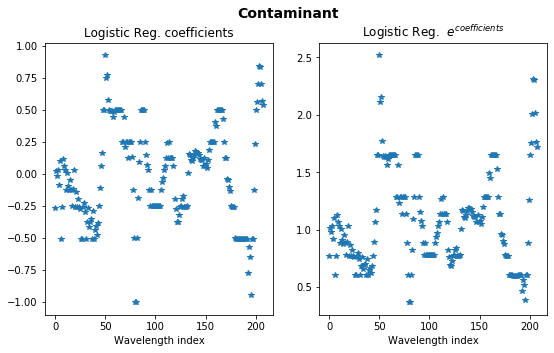

Ordered four most useful wavelengths are: [1108, 1660, 1664, 1115]nm
There corresponding indexes are: [ 50 203 204  52]


In [15]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [ ]:
print_current_time()

logreg = mypackage.LogReg(X_train_orig, Y_train_orig, C=1, penalty='l1', saved_mode_name="latest_LogisticReg_l1_model.sav")# , max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

2020-05-13 15:32:31.205254


In [ ]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [17]:
# mypackage.plot_labeled_images(Y_hat, Y_test)

In [18]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

2020-05-13 06:49:14.570884
Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.9401
Epoch 00001: val_loss improved from inf to 0.11553, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 62s 55ms/sample - loss: 0.3054 - accuracy: 0.9403 - val_loss: 0.1155 - val_accuracy: 0.9752
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9722
Epoch 00002: val_loss improved from 0.11553 to 0.07228, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 60s 53ms/sample - loss: 0.1073 - accuracy: 0.9723 - val_loss: 0.0723 - val_accuracy: 0.9772
Epoch 3/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9743
Epoch 00003: val_loss improved from 0.07228 to 0.06562, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 60s 53ms

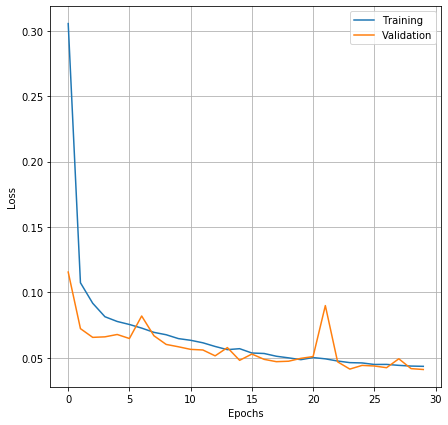

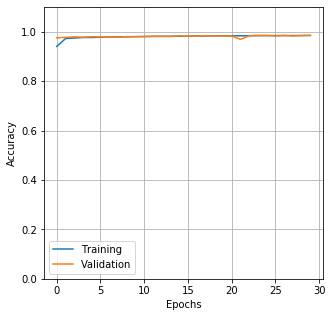

Predicting for train data
Elapsed time: 15.6621 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1074499
           1       0.96      0.96      0.96    201215
           2       0.82      0.66      0.74     14526

    accuracy                           0.99   1290240
   macro avg       0.92      0.87      0.90   1290240
weighted avg       0.99      0.99      0.99   1290240



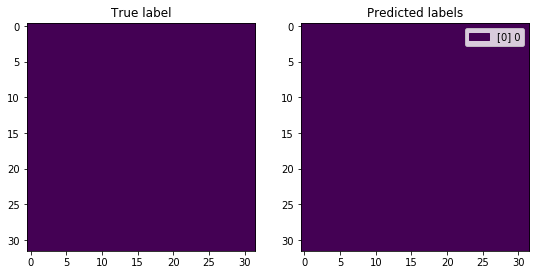

Predicting for test data
Elapsed time: 7.3087 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    453973
           1       0.97      0.96      0.96    122389
           2       0.81      0.62      0.71      7318

    accuracy                           0.98    583680
   macro avg       0.92      0.86      0.89    583680
weighted avg       0.98      0.98      0.98    583680



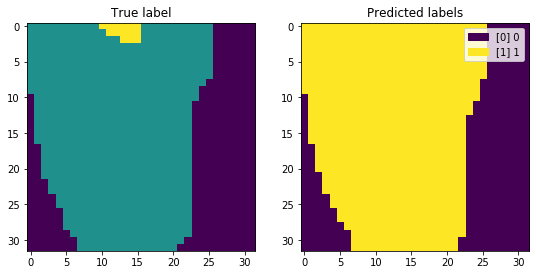

Elapsed time: 8.1766 seconds
Fasle positive blobs 51.
Fasle positive blobs per image 0.0895


In [19]:
print_current_time()

spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [20]:
# Max pooling
# spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
# print("Start training")
# timer.start()
# spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
# timer.stop()

# # spectral_unet.summary()
# spectral_unet.plot_training_results()
# print("Predicting for train data")
# spectral_unet.predict(X_train, Y_labels=Y_train)
# print("Predicting for test data")
# timer.start()
# y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
# timer.stop()
# mypackage.report_count_false_positive(y_pred_test, Y_test)

In [21]:
# spectral_unet.summary()

### Test 2D UNet on the same data

2020-05-13 07:19:43.253510
(1260, 32, 32, 208)
Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.3569 - accuracy: 0.9338
Epoch 00001: val_loss improved from inf to 0.09863, saving model to latest_unet.hdf5
1134/1134 [==============================] - 8s 7ms/sample - loss: 0.3561 - accuracy: 0.9339 - val_loss: 0.0986 - val_accuracy: 0.9785
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.9741
Epoch 00002: val_loss improved from 0.09863 to 0.06333, saving model to latest_unet.hdf5
1134/1134 [==============================] - 6s 5ms/sample - loss: 0.1019 - accuracy: 0.9741 - val_loss: 0.0633 - val_accuracy: 0.9805
Epoch 3/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9745
Epoch 00003: val_loss improved from 0.06333 to 0.05033, saving model to latest_unet.hdf5
1134/1134 [==============================] - 6s 5ms/sample - los

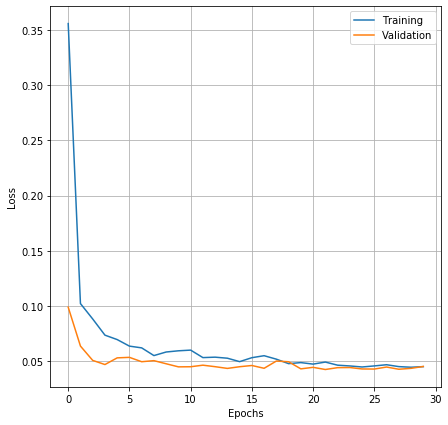

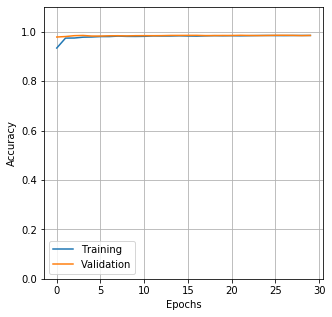

Predicting for train data
Elapsed time: 2.3574 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1074499
           1       0.95      0.97      0.96    201215
           2       0.85      0.58      0.69     14526

    accuracy                           0.99   1290240
   macro avg       0.93      0.85      0.88   1290240
weighted avg       0.99      0.99      0.99   1290240



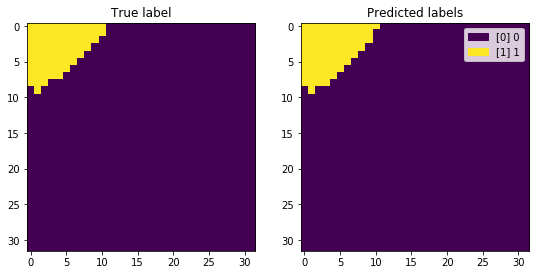

Predicting for test data
Elapsed time: 1.0001 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    453973
           1       0.97      0.96      0.96    122389
           2       0.76      0.69      0.72      7318

    accuracy                           0.98    583680
   macro avg       0.91      0.88      0.89    583680
weighted avg       0.98      0.98      0.98    583680



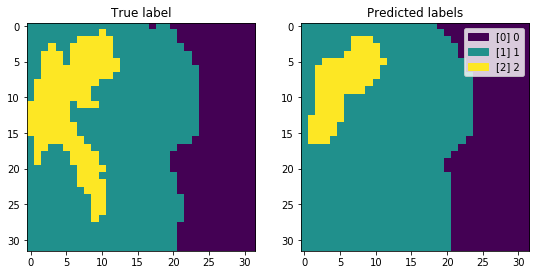

Elapsed time: 1.8683 seconds
Fasle positive blobs 54.
Fasle positive blobs per image 0.0947
Number of layers in the base model:  49


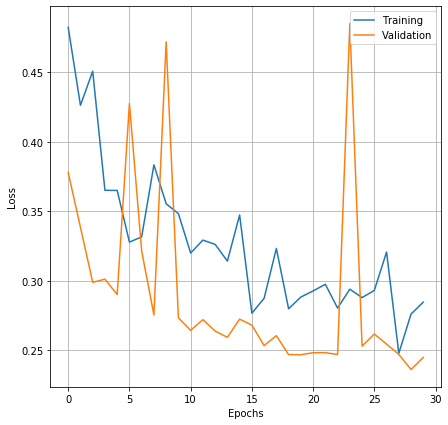

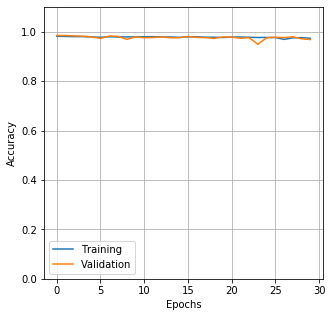

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 1.2491 seconds
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    453973
           1       0.99      0.86      0.92    122389
           2       0.77      0.80      0.79      7318

    accuracy                           0.97    583680
   macro avg       0.91      0.88      0.90    583680
weighted avg       0.97      0.97      0.97    583680



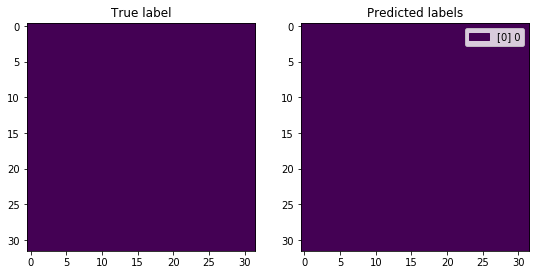

Fasle positive blobs 34.
Fasle positive blobs per image 0.0596


In [22]:
print_current_time()

# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [] # [7, 40, 68, 138, -1]
def select_channels(X_train):
    if X_train.shape[-1] <= 30:
        return X_train
    elif channels_used != []:
        return X_train[..., channels_used]
    else:
        return X_train
    
print(select_channels(X_train).shape)
unet = mypackage.UNet(select_channels(X_train), Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
# TODO: Test this more: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU -> monitor='val_mean_io_u'
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=1)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(select_channels(X_train), Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(select_channels(X_test), Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [23]:
# def get_classification_heat_map(y_hat, heat_maps):
#     heat = np.zeros(y_hat.shape)
#     heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
#     heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
#     heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
#     return heat

# def plot_with_heat_map(y_hat, heat_maps, y):
#     heat = get_classification_heat_map(y_hat, heat_maps)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(131)
#     plt.imshow(heat)
#     plt.colorbar()
#     plt.title("Model confidence of classification")
#     plt.subplot(132)
#     img = plt.imshow(y_hat)
#     mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
#     plt.title("Predicted labels")
#     plt.subplot(133)
#     img = plt.imshow(np.squeeze(y))
#     mypackage.Dataset._Dataset__add_legend_to_image(y, img)
#     plt.title("True labels")

# # y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
# for i in range(len(Y_test)):
#     if 2 in Y_test[i]:
#         plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
#         plt.suptitle(i)
        

Number of layers in the base model:  49


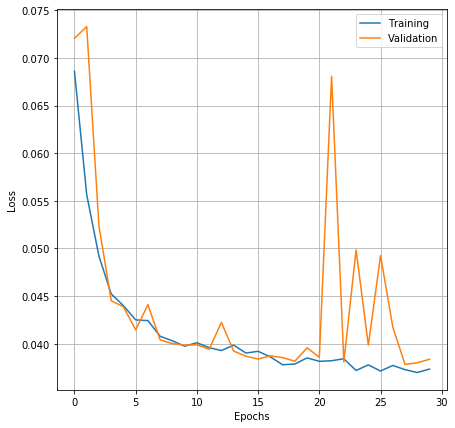

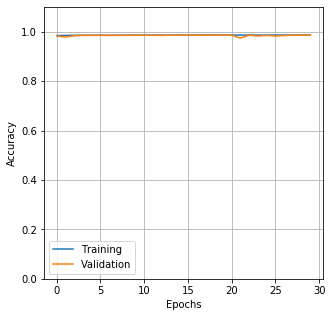

Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again
Elapsed time: 1.1801 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    453973
           1       0.98      0.95      0.97    122389
           2       0.74      0.79      0.77      7318

    accuracy                           0.99    583680
   macro avg       0.90      0.91      0.91    583680
weighted avg       0.99      0.99      0.99    583680



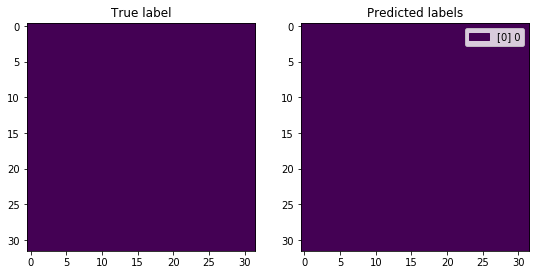

Fasle positive blobs 66.
Fasle positive blobs per image 0.1158


In [24]:
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss="categorical_crossentropy", validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [25]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))

In [ ]:
print("##################################")
print("# Additional HybridSN prediction #")
timer.start()
Y_hat = model.predict(X_test, Y_test)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test)